In [17]:
##Imports and setup for Jupyter

import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
from bs4 import BeautifulSoup
from IPython import display
import re
import plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go




import nltk
from nltk import corpus
from nltk.collocations import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import wordnet
from nltk import punkt
from nltk.util import ngrams
from nltk import FreqDist

from datetime import datetime as dt
from datetime import date


from string import punctuation
from collections import Counter
import numpy as np
from numpy import random

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import json

from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline


##function should allow to run in jupyter-- use show_app(#nameofapp) 

def show_app(app,  # type: dash.Dash
             port=9999,
             width=700,
             height=900,
             offline=True,
             style=True,
             **dash_flask_kwargs):
    """
    Run the application inside a Jupyter notebook and show an iframe with it
    :param app:
    :param port:
    :param width:
    :param height:
    :param offline:
    :return:
    """
    url = 'http://localhost:%d' % port
    iframe = '<iframe src="{url}" width={width} height={height}></iframe>'.format(url=url,
                                                                                  width=width,
                                                                                  height=height)
    display.display_html(iframe, raw=True)
    if offline:
        app.css.config.serve_locally = True
        app.scripts.config.serve_locally = True
    if style:
        external_css = ["https://fonts.googleapis.com/css?family=Raleway:400,300,600",
                        "https://maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css",
                        "http://getbootstrap.com/dist/css/bootstrap.min.css", ]

        for css in external_css:
            app.css.append_css({"external_url": css})

        external_js = ["https://code.jquery.com/jquery-3.2.1.min.js",
                       "https://cdn.rawgit.com/plotly/dash-app-stylesheets/a3401de132a6d0b652ba11548736b1d1e80aa10d/dash-goldman-sachs-report-js.js",
                       "http://getbootstrap.com/dist/js/bootstrap.min.js"]

        for js in external_js:
            app.scripts.append_script({"external_url": js})

    return app.run_server(debug=False,  # needs to be false in Jupyter
                          port=port,
                          **dash_flask_kwargs)



## General Dash Notes

anything that starts with html. ... is generating pure HTML, anything that comes from the dcc. library is using things like Javascript, CSS and HTML

can customize the CSS styles of the app---app.css.append_css()

have to stop the kernal and restart each time you'd like to 'retest' the app--- guessing that it stays running so that you can make interactive changes to it.

style property is best to supply a dictionary to (colors example)

dcc.Graph renders interactive data viz using JavaScript graphing library.

can write text in markdown... set something text equal to a variable and then use dcc.Markdown function



## Call backs (interactivity) notes

need to import dash.depencies (input output)

describe inputs and outputs through a app.callback decorator

the inputs and outputs of the application are simply the properties of a particular component (so for example a dcc.Input)

don't set a value for the children property of the my-div component in the layout... when Dash starts it automatically calls all of the callbacks with the inital values of the input components in order to population the initial start

It's reactive programming



In [22]:
##Importing the final report

##can I call something from another jupyter notebook? Seems like we might need to either have a massive setup beforehand or
##save the other file as a .py script and then import like that

report=pd.read_csv('connect_report.csv')

report['Created Date']=pd.to_datetime(report['Created Date'])
report=report[pd.notnull(report['Created Date'])]
report=report[pd.notnull(report['Body'])]

#Removing HTML tags and codes
report['Body'] = report['Body'].apply(lambda x:BeautifulSoup(x))
report['Body'] = report['Body'].apply(lambda x:x.get_text())

#Removing tags/mentions
report['Body'] = report['Body'].apply(lambda x:re.sub('{@[\w\d]*}', '',x))

#Removing urls
report['Body'] = report['Body'].apply(lambda x:re.sub(r'^https?:\/\/.*[\r\n]*', '', x,flags=re.MULTILINE))

#Removing weird unicode characters
report['Body'] = report['Body'].apply(lambda x: x.encode('ascii', 'ignore'))


final_report=pd.DataFrame

#Use this function to create the final report
# Directions:
# 1. Set Group to a list of group names, a single name of a group, or All to use all groups
# 2. Set Type to a specific Feed Item Type or All
# 3. Set Start Date or leave blank(defaults to: )
# 4. Set End Date or leave blank(defaults to: )

# def report_generator(Group,Type,Date_start=pd.to_datetime("2017-01-01"),Date_finish=pd.to_datetime('today')):
#     if type(Group) == list:
#         final_report=report.loc[report['Name'].isin(Group)] 
#     elif (Group=='All'):
#         final_report=report
#     else:
#         final_report=report.loc[report['Name']==Group]
                                
#     if (Type=='All'):
#         final_report=final_report
#     else:
#         final_report=final_report.loc[final_report['Feed Item Type']==Type]
    
#     if(Date_start=="2017-01-01" and Date_finish== pd.to_datetime('today')):
#         final_report=final_report
#     else:
#         Date_start=pd.to_datetime(Date_start, utc=False)
#         Date_finish=pd.to_datetime(Date_finish, utc=False)
#         #alt approach-- not working but not sure why-- it worked it worked it worked! had to change the data type to all be annoying ass datatime64... down the line that might be a pain but for now it's dope
#         final_report=final_report[(final_report['Created Date'] > Date_start) & (final_report['Created Date']< Date_finish)]   
#     return(final_report)

# final_report=report_generator(['CPC+ All','NLT Internal Users'],'All',"2017-02-01","2017-03-01")


def report_generator(Group,Type):
    if type(Group) == list:
        final_report=report.loc[report['Name'].isin(Group)] 
    elif (Group=='All'):
        final_report=report
    else:
        final_report=report.loc[report['Name']==Group]
                                
    if (Type=='All'):
        final_report=final_report
    else:
        final_report=final_report.loc[final_report['Feed Item Type']==Type]     
    return(final_report)

final_report=report_generator(['CPC+ All','NLT Internal Users'],'All')

stop = stopwords.words('english')
stop.append("cpc+")
stop.append("hi")
stop.append("hello")
stop.append("also")
stop.append("anyone")
stop.append("et")
stop.append("please")

wnl = WordNetLemmatizer() 


def tokenizer(text):
 
    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text.lower())]
    
    tokens = []
    
    for token_by_sent in tokens_:
        tokens += token_by_sent
 
    tokens = list(filter(lambda t: t not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(filter(lambda t: t not in [u"'s", u"n't",u"'ve",u"'re",u"'d",u"'ll",u"'m", u"u", 
                                             u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))
     
    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
 
    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
    
    bigrm = nltk.bigrams(filtered_tokens)
    bi_tokens = []
    for a, b in bigrm:
        bi_tok = ' '.join((a, b))
        bi_tokens.append(bi_tok)
    
    filtered_tokens.extend(bi_tokens)
    
    return filtered_tokens

def single_day_tracker(report):
    #Create the top 10 list
    unlisted_report=report['tokens'].apply(lambda x: ', '.join(x))

    word_vectorizer_2=CountVectorizer(ngram_range=(1,1), analyzer='word')
    word_vectorizer_fit_2=word_vectorizer_2.fit_transform(unlisted_report)

    frequencies=sum(word_vectorizer_fit_2).toarray()[0]

    bigrams_counter=pd.DataFrame(frequencies,index=word_vectorizer_2.get_feature_names(),columns=['frequency'])
    f = bigrams_counter[bigrams_counter['frequency']>10]
    
   
    f=f.sort_values(by=['frequency'],ascending=False)
    top_words=f.head(15)
    
    top_words_listed=list(top_words.index)


    #Okay now figure out what the frequency was each day
    unique_dates=set(report['Created Date'])
    list_dates=sorted(list(unique_dates))
    list_df_name=list(xrange(0,len(list_dates)))
    list_df=[]
    new_df=pd.DataFrame
    for i in xrange(0,len(list_dates)):
        date_report=report.loc[report['Created Date']==list_dates[i]]
        unlisted_report_date=unlisted_report=date_report['tokens'].apply(lambda x: ', '.join(x))
        word_vectorizer_fit_date=word_vectorizer_2.fit_transform(unlisted_report_date)
        frequencies_date=sum(word_vectorizer_fit_date).toarray()[0]
        bigrams_counter_date=pd.DataFrame(frequencies_date,index=word_vectorizer_2.get_feature_names(),columns=['frequency'])
        bigrams_date_listed=list(bigrams_counter_date.index)
        finder=(bigrams_counter_date.index.isin(top_words.index))
        slimmed=(bigrams_counter_date[finder])
        slimmed['word']=slimmed.index
        slimmed['date']=list_dates[i]
        slimmed['date']=pd.to_datetime(slimmed['date'])
        list_df_name[i]=slimmed
        list_df.append(list_df_name[i])
    new_df=pd.concat(list_df)
    new_df.index=xrange(0,len(new_df['word']))
    return(new_df)

##MOVED INTO REACTIVE SECTION BELOW
            
# top_words=single_day_tracker(final_report)


    
# #Bigrams/collocation scoring
# bigram_measures=nltk.collocations.BigramAssocMeasures()
# finder_2=BigramCollocationFinder.from_documents(final_report['tokens'])
# score_collocation_2=finder_2.nbest(bigram_measures.pmi,5)

# scored = finder_2.score_ngrams(bigram_measures.pmi)
# sorted_scored=sorted(bigram for bigram, score in scored)



#Single word finder
def single_word_finder(x,y,scorer,mode='single'):
    scores_e=list(enumerate(scorer))
    index_list=[]
    final_list=[]
    if(mode=='double'):
        for i, v in enumerate(scorer):
            if v[0] == (x,y):
                return scores_e[i]
            elif v[0] == (y,x):
                return scores_e[i]
    elif(mode=='single'):
        for i, v in enumerate(scorer):
            if(scores_e[i][1][0][0]) == x or scores_e[i][1][0][1] == x or scores_e[i][1][0][0]==y or scores_e[i][1][0][1]==y:
                index_list.append(i)
        for j in index_list:
            final_list.append(scores_e[j])
        return final_list

def graphing_single_word_finder(word1,scorer,mode='single'):
    graphing_data=single_word_finder(word1,'',scorer,'single')
    graphing_data=pd.Series(graphing_data)
    score_list=[]
    non_word1_list=[]
    for i,v in graphing_data.iteritems():
        if(graphing_data[i][1][0][0]!=word1):
            non_word1_list.append(graphing_data[i][1][0][0])
        elif(graphing_data[i][1][0][1])!=word1:
            non_word1_list.append(graphing_data[i][1][0][1])
        score_list.append(graphing_data[i][1][1])
    final_graphing=pd.concat([pd.Series(non_word1_list),pd.Series(score_list)],axis=1)
    final_graphing.columns=['Word','PMI_Score']
    sns.mpl.rc("figure", figsize=(9,4))
    word_graph=sns.stripplot(x="Word", y="PMI_Score", data=final_graphing, size = 8)
    loc, labels = plt.xticks()
    word_graph.set_xticklabels(labels, rotation=90)
    return(final_graphing)

def graphing_labels(word1,scorer,mode='single'):
    graphing_data=single_word_finder(word1,'',scorer,'single')
    graphing_data=pd.Series(graphing_data)
    score_list=[]
    non_word1_list=[]
    for i,v in graphing_data.iteritems():
        if(graphing_data[i][1][0][0]!=word1):
            non_word1_list.append(graphing_data[i][1][0][0])
        elif(graphing_data[i][1][0][1])!=word1:
            non_word1_list.append(graphing_data[i][1][0][1])
        score_list.append(graphing_data[i][1][1])
    final_graphing=pd.concat([pd.Series(non_word1_list),pd.Series(score_list)],axis=1)
    final_graphing.columns=['Word','PMI_Score']
    return(final_graphing)

In [14]:
##Setting up table generator example
def generate_table(dataframe, maxrows=10):
    return html.Table(
        # Header
        [html.Tr([html.Th(col) for col in dataframe.columns])] +

        # Body
        [html.Tr([
            html.Td(dataframe.iloc[i][col]) for col in dataframe.columns
        ]) for i in range(min(len(dataframe), maxrows))]
    )


In [15]:
##Text Example

example_text='''
## This is where we would write an intro.

Maybe something about how to use the dashboard, or how to get it to run.
Explanation of scores, things like that.
'''

In [ ]:
##Setting up a test environment



app=dash.Dash()



colors={
    'background': '#111111',
    'text': '#7FDBFF'
}

app.layout=html.Div(children=
    [html.H1(children='This is the title pane',
             style={
                 'textAlign': 'center', 'color':colors['text']}   ),
    dcc.Markdown(children=example_text), 
    html.H2(children='Please use these inputs to customize your report',
            style={
                 'textAlign': 'center', 'color':colors['text']} ),
    dcc.DatePickerRange(
        id='date_selector',
        min_date_allowed=dt(2017,1,1),
        end_date=dt.today()),
    html.Table(id='table'), 
#Need to work on spacing here and then figure out how to use them as arguments for all of the functions  
#     html.Label('First word finder'),
#     dcc.Input(
#         id='first_word_finder',
#         value='',
#         type='text'),
#     html.Label('Second word finder'),
#     dcc.Input(value='If you would like to find the intersection of the first word and another please enter here',type='text'),
#     ##Try to build the graph here 
#     dcc.Graph(
#         id='test_graph', 
        
#     ),
     
    
     
     html.Div(id='output-container-date-selector',style={'display': 'none'}),
     html.Div(id='output-container-top-words',style={'display':'none'}),
     html.Div(id="output-container-scored",style={'display':'none'})
     
    
])



#Need to move things that are setup/dependent on reactive inputs here into here
@app.callback(
    dash.dependencies.Output('output-container-date-selector','children'),
[dash.dependencies.Input('date_selector','start_date'),
 dash.dependencies.Input('date_selector','end_date')]
)
##going to need to do this in a bunch of different functions?
def update_report(final_report,input1,input2):
    if(input1=="2017-01-01" and input2== pd.to_datetime('today')):
        final_report_reactive=final_report
    else:
        start=pd.to_datetime(input1, utc=False)
        end=pd.to_datetime(input2, utc=False)
        final_report_reactive=final_report[(final_report['Created Date'] > start) & (final_report['Created Date']< end)]   
    return(final_report_reactive.to_json())

#Testing on the table
@app.callback(dash.dependencies.Output('table','children'),
             [dash.dependencies.Input('output-container-date-selector','children')]
             )
def update_table(input1):
    final_report_updated=pd.read_json(input1)
    reactive_table=create_table(final_report_updated)
    return(reactive_table)

# @app.callback(dash.dependencies.Output('output-container-top-words','children'),
#              dash.dependencies.Input('output-container-date-selector','children')
#              )
# def update_top_words(input):
#     top_words_reactive=single_day_tracker(input)
#     return(top_words_reactive.to_json())

# @app.callback(dash.dependencies.Output('output-container-scored','children'),
#             [dash.dependencies.Input('output-container-top-words','children'),
#               dash.dependencies.Input('output-container-date-selector','children')]
#              )
# def update_scores(input1): 
# #Bigrams/collocation scoring
#     bigram_measures=nltk.collocations.BigramAssocMeasures()
#     finder_2=BigramCollocationFinder.from_documents(input2['tokens'])
#     score_collocation_2=finder_2.nbest(bigram_measures.pmi,5)

#     scored = finder_2.score_ngrams(bigram_measures.pmi)
#     sorted_scored_reactive=sorted(bigram for bigram, score in scored)
#     return(sorted_scored_reactive)


# @app.callback(
#     dash.dependencies.Output('test_graph','figure'),
#     [dash.dependencies.Input('first_word_finder','value'),
#     dash.dependencies.Input('output-container-scored')]
# )

# def update_graph(input1,input2):

#     pmi_score=graphing_single_word_finder(input1,'',mode='single')
#     g_labels=graphing_labels(input2,'',mode='single')
#     g_labels=g_labels['Word'].tolist()
#     return{
#             'data': [
#                 go.Scatter(
#                 x=pmi_score['Word'],
#                 y=pmi_score['PMI_Score'],
#                 mode='markers',
#                     marker=dict(
#                     color=range(0,len(pmi_score)),
#                     cmin=0,
#                     cmax=28,
#                     colorscale='Jet'
#                 )
#                 )
#                 ],
#             'layout':go.Layout(
#                 xaxis={'title':'PMI for Searched words','ticktext':g_labels}
#                 )
#    }


show_app(app)

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [11/Dec/2017 09:57:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2017 09:57:07] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2017 09:57:07] "GET /_dash-dependencies HTTP/1.1" 200 -
C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

127.0.0.1 - - [11/Dec/2017 09:57:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2017 09:57:11] "GET /favicon.ico HTTP/1.1" 200 -
127.0.0.1 - - [11/Dec/2017 09:57:11] "POST /_dash-update-component HTTP/1.1" 200 -
C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:154: SettingWith

127.0.0.1 - - [11/Dec/2017 10:02:34] "POST /_dash-update-component HTTP/1.1" 500 -
[2017-12-11 10:02:35,338] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1612, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1598

127.0.0.1 - - [11/Dec/2017 10:02:42] "POST /_dash-update-component HTTP/1.1" 500 -
[2017-12-11 10:02:43,591] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1612, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1598

127.0.0.1 - - [11/Dec/2017 10:03:33] "POST /_dash-update-component HTTP/1.1" 500 -
[2017-12-11 10:03:35,253] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1612, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1598

127.0.0.1 - - [11/Dec/2017 10:03:39] "POST /_dash-update-component HTTP/1.1" 500 -
[2017-12-11 10:03:40,448] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1612, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1598

127.0.0.1 - - [11/Dec/2017 10:03:44] "POST /_dash-update-component HTTP/1.1" 500 -
[2017-12-11 10:03:46,407] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1612, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1598

127.0.0.1 - - [11/Dec/2017 10:03:53] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [11/Dec/2017 10:03:55] "POST /_dash-update-component HTTP/1.1" 200 -
[2017-12-11 10:27:03,430] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\flask\app.py", line 1612, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\583185\App

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61358)
----------------------------------------


Traceback (most recent call last):
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\SocketServer.py", line 290, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\SocketServer.py", line 318, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\SocketServer.py", line 331, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\SocketServer.py", line 652, in __init__
    self.handle()
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\werkzeug\serving.py", line 232, in handle
    rv = BaseHTTPRequestHandler.handle(self)
  File "C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\BaseHTTPServer.py", line 340, in handle
    self.handle_one_request

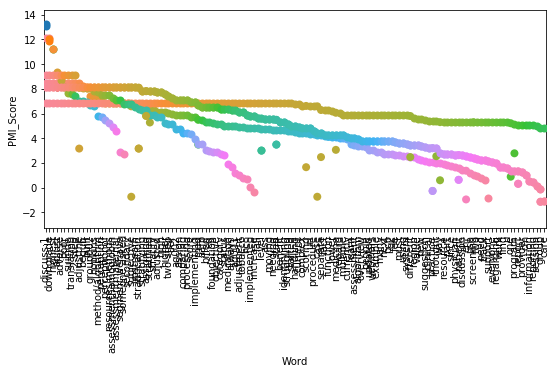

In [23]:
##Run the app in broswer instead

app=dash.Dash()

report=pd.read_csv('connect_report.csv')

report['Created Date']=pd.to_datetime(report['Created Date'])
report=report[pd.notnull(report['Created Date'])]
report=report[pd.notnull(report['Body'])]

#Removing HTML tags and codes
report['Body'] = report['Body'].apply(lambda x:BeautifulSoup(x))
report['Body'] = report['Body'].apply(lambda x:x.get_text())

#Removing tags/mentions
report['Body'] = report['Body'].apply(lambda x:re.sub('{@[\w\d]*}', '',x))

#Removing urls
report['Body'] = report['Body'].apply(lambda x:re.sub(r'^https?:\/\/.*[\r\n]*', '', x,flags=re.MULTILINE))

#Removing weird unicode characters
report['Body'] = report['Body'].apply(lambda x: x.encode('ascii', 'ignore'))

final_report=pd.DataFrame(data=report)
final_report= final_report.reset_index(drop=True)






colors={
    'background': '#111111',
    'text': '#7FDBFF'
}

app.layout=html.Div(children=
    [html.H1(children='This is the title pane',
             style={
                 'textAlign': 'center', 'color':colors['text']}   ),
    dcc.Markdown(children=example_text), 
    html.H2(children='Please use these inputs to customize your report',
            style={
                 'textAlign': 'center', 'color':colors['text']} ),
    dcc.DatePickerRange(
        id='date_selector',
        min_date_allowed=dt(2017,1,1),
        start_date=dt(2017,1,1),
        end_date=dt.today()),
      html.Label('First word finder'),
    dcc.Input(
        id='first_word_finder',
        value='',
        type='text'),
    html.Table(id='table'), 

    ##Try to build the graph here 
    dcc.Graph(
        id='test_graph', 
        
    ),
     
    
     
     html.Div(id='output-container-date-selector',style={'display': 'none'}),
     html.Div(id='output-container-top-words',style={'display':'none'}),
     html.Div(id="output-container-scored",style={'display':'none'})
     
    
])



#Need to move things that are setup/dependent on reactive inputs here into here
@app.callback(
    dash.dependencies.Output('output-container-date-selector','children'),
[dash.dependencies.Input('date_selector','start_date'),
 dash.dependencies.Input('date_selector','end_date')]
)
##going to need to do this in a bunch of different functions?
def update_report(start_date,end_date):
    start=pd.to_datetime(start_date,format ='%Y-%m-%d',utc=False)
    end=pd.to_datetime(end_date,format = '%Y-%m-%d', utc=False)
    
    final_report_reactive=final_report[(final_report['Created Date'] > start) & (final_report['Created Date']< end)] 
    #tokenizes final report
    final_report_reactive['tokens'] = final_report_reactive['Body'].map(tokenizer)
    final_report_reactive=final_report_reactive.reset_index(drop=True)
    json_save=final_report_reactive.to_json(orient="records")

    return json_save

@app.callback(dash.dependencies.Output('output-container-top-words','children'),
              [dash.dependencies.Input('output-container-date-selector','children')]
              )
def update_top_words(input1):
    finalized_report_reactive=pd.read_json(input1)
    top_words_reactive=single_day_tracker(finalized_report_reactive)
    return(top_words_reactive.to_json())

@app.callback(dash.dependencies.Output('test_graph','figure'),[dash.dependencies.Input('output-container-date-selector','children'),
                                                                  dash.dependencies.Input('output-container-top-words','children'),dash.dependencies.Input('first_word_finder','value')])
def update_graph(input1,input2,word):
    #Bigrams/collocation scoring
    finalized_report_reactive=pd.read_json(input1)
    bigram_measures=nltk.collocations.BigramAssocMeasures()
    finder_2=BigramCollocationFinder.from_documents(finalized_report_reactive['tokens'])
    score_collocation_2=finder_2.nbest(bigram_measures.pmi,5)

    scored_reactive = finder_2.score_ngrams(bigram_measures.pmi)
    sorted_scored_reactive=sorted(bigram for bigram, score in scored_reactive)
    
    pmi_score=graphing_single_word_finder(word,scored_reactive,mode='single')
    g_labels=graphing_labels(word,scored_reactive,mode='single')
    g_labels=g_labels['Word'].tolist()
    return{
            'data': [
                go.Scatter(
                x=pmi_score['Word'],
                y=pmi_score['PMI_Score'],
                mode='markers',
                    marker=dict(
                    color=range(0,len(pmi_score)),
                    cmin=0,
                    cmax=28,
                    colorscale='Jet'
                )
                )
                ],
            'layout':go.Layout(
                xaxis={'title':'PMI for Searched words','ticktext':g_labels}
                )
   }



#Testing on the table
@app.callback(dash.dependencies.Output('table','children'),
             [dash.dependencies.Input('output-container-date-selector','children')]
             )
def update_table(updated_data):
    final_report_updated=pd.read_json(updated_data,orient ="records")
    table=generate_table(final_report_updated)
    return table


if __name__ == '__main__':
    app.run_server()

In [19]:
final_report_test=final_report[(final_report['Created Date']>"2017-04-01") & (final_report['Created Date'] < "2017-05-01")]
json_test=final_report_test.to_json(orient='records')

json_string=(json.dumps(json_test))

data = pd.read_json(json_test)

pd.to_datetime("1/1/2017")

Timestamp('2017-01-01 00:00:00')

In [20]:
data.head()

,Body,Comment Count,Created By: Company Name,Created By: Full Name,Created Date,Feed Item Type,Like Count,Name,Network: Name
0,Question on reporting 5.1 Team Based Care and ...,1,"Mark W. Hinman, MD, LLC",Mark Hinman,1491091200000,Text Post,0,CPC+ All,CPC Plus Connect
1,Check out the latest ?On the Plus Side? weekly...,0,BAH,Sam Gottuso,1491177600000,Content Post,1,CPC+ All,CPC Plus Connect
2,We are in the process of wanting to hire a Car...,5,NY,Jacklyn Peele,1491177600000,Text Post,0,Role Group: Care Managers,CPC Plus Connect
3,A reminder for all practices: Your practice sh...,0,BAH,Amy Gibson,1491177600000,Content Post,0,CPC+ All,CPC Plus Connect
4,Did you miss the Care Delivery and eCQM Office...,0,Booz Allen Hamilton,Walker Sands,1491177600000,Link Post,2,CPC+ All,CPC Plus Connect


In [21]:
data.reset_index(drop=True)

,Body,Comment Count,Created By: Company Name,Created By: Full Name,Created Date,Feed Item Type,Like Count,Name,Network: Name
0,Question on reporting 5.1 Team Based Care and ...,1,"Mark W. Hinman, MD, LLC",Mark Hinman,1491091200000,Text Post,0,CPC+ All,CPC Plus Connect
1,Check out the latest ?On the Plus Side? weekly...,0,BAH,Sam Gottuso,1491177600000,Content Post,1,CPC+ All,CPC Plus Connect
2,We are in the process of wanting to hire a Car...,5,NY,Jacklyn Peele,1491177600000,Text Post,0,Role Group: Care Managers,CPC Plus Connect
3,A reminder for all practices: Your practice sh...,0,BAH,Amy Gibson,1491177600000,Content Post,0,CPC+ All,CPC Plus Connect
4,Did you miss the Care Delivery and eCQM Office...,0,Booz Allen Hamilton,Walker Sands,1491177600000,Link Post,2,CPC+ All,CPC Plus Connect
5,Did you miss theCPC+ Learning and Data Feedbac...,0,BAH,Sam Gottuso,1491177600000,Link Post,0,All Payers,CPC Plus Connect
6,"On the Oregon call last week, one group mentio...",10,Northwest Primary Care Group PC,Mike Salvey,1491177600000,Text Post,9,CPC+ All,CPC Plus Connect
7,Hi everyone!and I are very excited to kick off...,22,HealthTeamWorks,Jennifer Boaz,1491264000000,Text Post,5,AG001: Risk Stratification,CPC Plus Connect
8,Hi everyone!and I are very excited to kick off...,0,HealthTeamWorks,Jennifer Boaz,1491264000000,Text Post,2,AG002: Risk Stratification,CPC Plus Connect
9,Want to closely track the CPC+ Program Year 20...,0,None,Bridget Lalley Ryder,1491264000000,Content Post,0,CPC+ All,CPC Plus Connect


In [ ]:
#Testing on the table
@app.callback(dash.dependencies.Output('table','children'),
             [dash.dependencies.Input('output-container-date-selector','children')]
             )
def update_table(input1):
    final_report_updated=pd.read_json(json.loads(input1),orient='index')
    reactive_table=html.Table(final_report_updated)
    return(reactive_table)